In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import tensorflow as tf
keras = tf.keras

In [2]:
def plot_series(time,series,format="-",start=0,end=None,label=None):
    plt.plot(time[start:end], series[start:end],format,label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

    
def trend(time,slope=0):
    return slope*time
    
#seasonal Data
def seasonal_pattern(season_time):
    return np.where(season_time< 0.4,np.cos(season_time*2*np.pi),
                   1/np.exp(3*season_time))

def seasonality(time,period,amplitude=1,phase=0):
    season_time = ((time+phase)%period)/period
    return amplitude*seasonal_pattern(season_time)

# noise
def white_noise(time,noise_level=1,seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


In [3]:
time = np.arange(4*365+1)
slope = 0.05
baseline = 10
amplitude = 40

In [4]:
series = baseline+trend(time,slope)+seasonality(time,period=365,amplitude=amplitude)
noise_level = 5
noise = white_noise(time,noise_level,seed=42)
series += noise

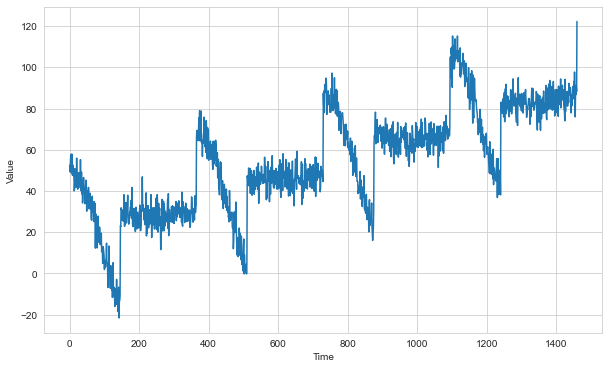

In [5]:
plt.figure(figsize=(10,6))
plot_series(time,series)
plt.show()

In [6]:
def window_dataset(series,window_size,batch_size=32,shuffle_buffer=100):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1,shift=1,drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window:(window[:-1],window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [7]:
split_time = 1000
time_train = time[:split_time]
X_train = series[:split_time]
time_valid = time[split_time:]
X_valid = series[split_time:]

In [8]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 30


In [9]:
train_set = window_dataset(X_train,window_size)

In [10]:
valid_set = window_dataset(X_valid,window_size)

In [11]:
model = keras.models.Sequential([
    keras.layers.Dense(1,input_shape=[window_size])
])

In [12]:
optimizer = keras.optimizers.SGD(learning_rate=1e-5,momentum=0.9)
model.compile(loss=keras.losses.Huber(),optimizer=optimizer,metrics=['mae'])

In [13]:
model.fit(train_set,epochs=10,validation_data=valid_set)

Epoch 1/10
31/31 [==============================] - 7s 42ms/step - loss: 46.1206 - mae: 46.6184 - val_loss: 22.6505 - val_mae: 23.1480
Epoch 2/10
31/31 [==============================] - 1s 22ms/step - loss: 12.9972 - mae: 13.4914 - val_loss: 9.7567 - val_mae: 10.2430
Epoch 3/10
31/31 [==============================] - 1s 19ms/step - loss: 10.2358 - mae: 10.7224 - val_loss: 9.5453 - val_mae: 10.0338
Epoch 4/10
31/31 [==============================] - 1s 19ms/step - loss: 9.9075 - mae: 10.3946 - val_loss: 9.0303 - val_mae: 9.5171
Epoch 5/10
31/31 [==============================] - 1s 21ms/step - loss: 9.6916 - mae: 10.1777 - val_loss: 8.9544 - val_mae: 9.4409
Epoch 6/10
31/31 [==============================] - 1s 21ms/step - loss: 9.6016 - mae: 10.0882 - val_loss: 8.8398 - val_mae: 9.3257
Epoch 7/10
31/31 [==============================] - 1s 22ms/step - loss: 9.5063 - mae: 9.9916 - val_loss: 8.7349 - val_mae: 9.2208
Epoch 8/10
31/31 [==============================] - 1s 18ms/step - los

In [14]:
# Tunning

In [15]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 30


In [16]:
train_set = window_dataset(X_train,window_size)

In [17]:
model = keras.models.Sequential([
    keras.layers.Dense(1,input_shape=[window_size])
])

In [18]:
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6*10**(epoch/30))

In [19]:
optimizer = keras.optimizers.SGD(learning_rate=1e-6,momentum=0.9)

In [20]:
model.compile(loss=keras.losses.Huber(),optimizer=optimizer,metrics=['mae'])

In [21]:
history = model.fit(train_set,epochs=100,callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 10ms/step - loss: 67.8742 - mae: 68.3736
Epoch 2/100
31/31 [==============================] - 0s 10ms/step - loss: 52.3215 - mae: 52.8210
Epoch 3/100
31/31 [==============================] - 0s 9ms/step - loss: 34.5646 - mae: 35.0641
Epoch 4/100
31/31 [==============================] - 0s 10ms/step - loss: 17.4121 - mae: 17.9097
Epoch 5/100
31/31 [==============================] - 0s 9ms/step - loss: 8.4748 - mae: 8.9634
Epoch 6/100
31/31 [==============================] - 0s 8ms/step - loss: 7.9550 - mae: 8.4387
Epoch 7/100
31/31 [==============================] - 0s 9ms/step - loss: 7.9192 - mae: 8.4030
Epoch 8/100
31/31 [==============================] - 0s 9ms/step - loss: 7.8699 - mae: 8.3530
Epoch 9/100
31/31 [==============================] - 0s 8ms/step - loss: 7.8274 - mae: 8.3111
Epoch 10/100
31/31 [==============================] - 0s 8ms/step - loss: 7.7713 - mae: 8.2553
Epoch 11/100
31/31 [============================

31/31 [==============================] - 0s 9ms/step - loss: 24.3876 - mae: 24.8843
Epoch 87/100
31/31 [==============================] - 0s 10ms/step - loss: 34.4507 - mae: 34.9481
Epoch 88/100
31/31 [==============================] - 0s 10ms/step - loss: 20.0376 - mae: 20.5297
Epoch 89/100
31/31 [==============================] - 0s 9ms/step - loss: 31.7169 - mae: 32.2107
Epoch 90/100
31/31 [==============================] - 0s 10ms/step - loss: 55.9358 - mae: 56.4334
Epoch 91/100
31/31 [==============================] - 0s 10ms/step - loss: 26.4369 - mae: 26.9306
Epoch 92/100
31/31 [==============================] - 0s 11ms/step - loss: 41.6106 - mae: 42.1072
Epoch 93/100
31/31 [==============================] - 0s 11ms/step - loss: 56.4310 - mae: 56.9260
Epoch 94/100
31/31 [==============================] - 0s 10ms/step - loss: 68.0822 - mae: 68.5806
Epoch 95/100
31/31 [==============================] - 0s 11ms/step - loss: 56.8672 - mae: 57.3649
Epoch 96/100
31/31 [===============

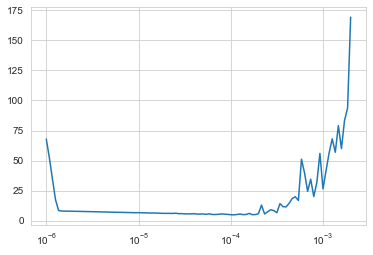

In [22]:
plt.semilogx(history.history['lr'],history.history['loss'])
#plt.axis(1e-6,1e-3,0,20)
plt.show()

In [23]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 30


In [24]:
train_set = window_dataset(X_train,window_size)
valid_set = window_dataset(X_valid,window_size)


In [25]:
model = keras.models.Sequential([
    keras.layers.Dense(1,input_shape=[window_size])
])

In [26]:
optimizer = keras.optimizers.SGD(learning_rate=1e-5,momentum=0.9)
model.compile(loss=keras.losses.Huber(),optimizer=optimizer,metrics=['mae'])

In [27]:
early_stooping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set,epochs=500,validation_data=valid_set,callbacks=[early_stooping])

Epoch 1/500
31/31 [==============================] - 2s 30ms/step - loss: 46.1206 - mae: 46.6184 - val_loss: 22.6505 - val_mae: 23.1480
Epoch 2/500
31/31 [==============================] - 1s 20ms/step - loss: 12.9972 - mae: 13.4914 - val_loss: 9.7567 - val_mae: 10.2430
Epoch 3/500
31/31 [==============================] - 1s 19ms/step - loss: 10.2358 - mae: 10.7224 - val_loss: 9.5453 - val_mae: 10.0338
Epoch 4/500
31/31 [==============================] - 1s 18ms/step - loss: 9.9075 - mae: 10.3946 - val_loss: 9.0303 - val_mae: 9.5171
Epoch 5/500
31/31 [==============================] - 1s 17ms/step - loss: 9.6916 - mae: 10.1777 - val_loss: 8.9544 - val_mae: 9.4409
Epoch 6/500
31/31 [==============================] - 1s 20ms/step - loss: 9.6016 - mae: 10.0882 - val_loss: 8.8398 - val_mae: 9.3257
Epoch 7/500
31/31 [==============================] - 1s 21ms/step - loss: 9.5063 - mae: 9.9916 - val_loss: 8.7349 - val_mae: 9.2208
Epoch 8/500
31/31 [==============================] - 1s 20ms/st

31/31 [==============================] - 1s 20ms/step - loss: 5.8225 - mae: 6.3053 - val_loss: 5.8538 - val_mae: 6.3326
Epoch 63/500
31/31 [==============================] - 1s 19ms/step - loss: 5.8022 - mae: 6.2832 - val_loss: 5.9874 - val_mae: 6.4752
Epoch 64/500
31/31 [==============================] - 1s 21ms/step - loss: 5.8281 - mae: 6.3121 - val_loss: 5.8108 - val_mae: 6.2877
Epoch 65/500
31/31 [==============================] - 1s 19ms/step - loss: 5.7616 - mae: 6.2451 - val_loss: 5.7749 - val_mae: 6.2605
Epoch 66/500
31/31 [==============================] - 1s 19ms/step - loss: 5.7429 - mae: 6.2238 - val_loss: 5.9297 - val_mae: 6.4167
Epoch 67/500
31/31 [==============================] - 1s 20ms/step - loss: 5.7236 - mae: 6.2011 - val_loss: 5.7453 - val_mae: 6.2220
Epoch 68/500
31/31 [==============================] - 1s 21ms/step - loss: 5.6514 - mae: 6.1317 - val_loss: 5.7405 - val_mae: 6.2264
Epoch 69/500
31/31 [==============================] - 1s 19ms/step - loss: 5.6390 

31/31 [==============================] - 1s 16ms/step - loss: 4.6936 - mae: 5.1697 - val_loss: 4.9500 - val_mae: 5.4245
Epoch 124/500
31/31 [==============================] - 1s 20ms/step - loss: 4.6846 - mae: 5.1607 - val_loss: 4.9098 - val_mae: 5.3913
Epoch 125/500
31/31 [==============================] - 1s 20ms/step - loss: 4.7654 - mae: 5.2407 - val_loss: 5.0137 - val_mae: 5.4916
Epoch 126/500
31/31 [==============================] - 1s 18ms/step - loss: 4.6762 - mae: 5.1504 - val_loss: 4.9618 - val_mae: 5.4383
Epoch 127/500
31/31 [==============================] - 1s 20ms/step - loss: 4.6986 - mae: 5.1747 - val_loss: 4.8968 - val_mae: 5.3847
Epoch 128/500
31/31 [==============================] - 1s 19ms/step - loss: 4.7264 - mae: 5.1985 - val_loss: 4.8714 - val_mae: 5.3559
Epoch 129/500
31/31 [==============================] - 1s 18ms/step - loss: 4.7635 - mae: 5.2351 - val_loss: 4.8656 - val_mae: 5.3458
Epoch 130/500
31/31 [==============================] - 1s 19ms/step - loss: 

31/31 [==============================] - 1s 19ms/step - loss: 4.4097 - mae: 4.8846 - val_loss: 4.6351 - val_mae: 5.1106
Epoch 185/500
31/31 [==============================] - 1s 19ms/step - loss: 4.5008 - mae: 4.9745 - val_loss: 4.6329 - val_mae: 5.1129
Epoch 186/500
31/31 [==============================] - 1s 21ms/step - loss: 4.3992 - mae: 4.8716 - val_loss: 4.6934 - val_mae: 5.1740
Epoch 187/500
31/31 [==============================] - 1s 22ms/step - loss: 4.4010 - mae: 4.8706 - val_loss: 4.5694 - val_mae: 5.0410
Epoch 188/500
31/31 [==============================] - 1s 21ms/step - loss: 4.4756 - mae: 4.9519 - val_loss: 4.6185 - val_mae: 5.0974
Epoch 189/500
31/31 [==============================] - 1s 19ms/step - loss: 4.3695 - mae: 4.8426 - val_loss: 4.5737 - val_mae: 5.0453
Epoch 190/500
31/31 [==============================] - 1s 20ms/step - loss: 4.4241 - mae: 4.8988 - val_loss: 4.7603 - val_mae: 5.2439
Epoch 191/500
31/31 [==============================] - 1s 17ms/step - loss: 

In [28]:
def model_forcast(model,series,window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size,shift=1,drop_remainder=True)
    ds = ds.flat_map(lambda w:w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [29]:
lin_forecast = model_forcast(model,series[split_time-window_size:-1],window_size)[:,0]

In [30]:
lin_forecast

array([ 67.659874,  70.12948 ,  72.31463 ,  68.371635,  67.01837 ,
        69.49941 ,  68.07596 ,  67.81586 ,  69.93147 ,  69.44404 ,
        68.7576  ,  69.418724,  70.164215,  71.96255 ,  68.54154 ,
        71.14352 ,  69.81809 ,  68.09003 ,  67.488846,  65.72355 ,
        66.84463 ,  66.380974,  67.253044,  66.47716 ,  69.55901 ,
        71.25313 ,  72.296906,  68.84385 ,  71.79453 ,  68.43336 ,
        68.65885 ,  65.09608 ,  64.11993 ,  65.11672 ,  66.240616,
        64.994965,  69.9112  ,  65.53094 ,  65.48444 ,  65.19525 ,
        68.54243 ,  71.33856 ,  66.809525,  69.664696,  69.63618 ,
        69.05121 ,  70.85322 ,  68.34072 ,  67.265755,  69.125984,
        70.79506 ,  69.82267 ,  66.8657  ,  69.56954 ,  70.5662  ,
        66.68699 ,  67.94606 ,  66.76575 ,  68.88822 ,  68.380104,
        67.513695,  70.53153 ,  64.96454 ,  66.10305 ,  65.73783 ,
        64.83287 ,  63.307392,  63.262043,  65.85188 ,  65.098434,
        68.07926 ,  67.25358 ,  69.023384,  69.03829 ,  66.635

In [31]:
lin_forecast.shape

(461,)

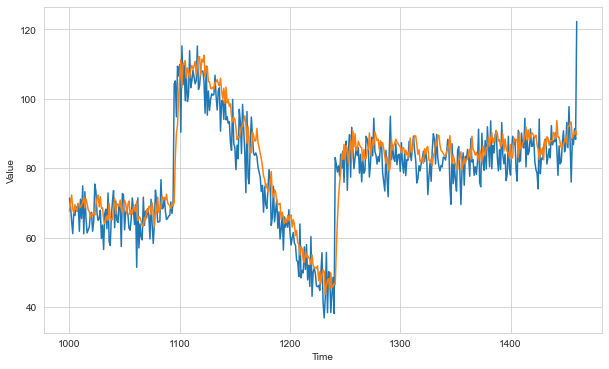

In [32]:
plt.figure(figsize=(10,6))
plot_series(time_valid,X_valid)
plot_series(time_valid,lin_forecast)

In [33]:
# Dense Model 

In [34]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 30
train_set = window_dataset(X_train,window_size)

In [35]:
model = keras.models.Sequential([
    keras.layers.Dense(10,activation='relu',input_shape=[window_size]),
    keras.layers.Dense(10,activation='relu'),
    keras.layers.Dense(1)
])

In [36]:
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-7*10**(epoch/20))

In [37]:
optimizer = keras.optimizers.SGD(learning_rate=1e-7,momentum=0.9)
model.compile(loss=keras.losses.Huber(),optimizer=optimizer,metrics=['mae'])
history = model.fit(train_set,epochs=100,callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 15ms/step - loss: 43.8531 - mae: 44.3525
Epoch 2/100
31/31 [==============================] - 0s 10ms/step - loss: 41.5277 - mae: 42.0270
Epoch 3/100
31/31 [==============================] - 0s 9ms/step - loss: 38.6320 - mae: 39.1319
Epoch 4/100
31/31 [==============================] - 0s 10ms/step - loss: 35.3337 - mae: 35.8335
Epoch 5/100
31/31 [==============================] - 0s 10ms/step - loss: 31.5666 - mae: 32.0664
Epoch 6/100
31/31 [==============================] - 0s 11ms/step - loss: 27.3571 - mae: 27.8561
Epoch 7/100
31/31 [==============================] - 0s 10ms/step - loss: 22.7112 - mae: 23.2097
Epoch 8/100
31/31 [==============================] - 0s 11ms/step - loss: 17.6612 - mae: 18.1586
Epoch 9/100
31/31 [==============================] - 0s 10ms/step - loss: 12.4678 - mae: 12.9616
Epoch 10/100
31/31 [==============================] - 0s 11ms/step - loss: 8.3082 - mae: 8.7977
Epoch 11/100
31/31 [============

31/31 [==============================] - 0s 11ms/step - loss: 41.6080 - mae: 42.1062
Epoch 87/100
31/31 [==============================] - 0s 12ms/step - loss: 40.9835 - mae: 41.4810
Epoch 88/100
31/31 [==============================] - 0s 11ms/step - loss: 40.4012 - mae: 40.8990
Epoch 89/100
31/31 [==============================] - 0s 10ms/step - loss: 39.7560 - mae: 40.2543
Epoch 90/100
31/31 [==============================] - 0s 11ms/step - loss: 39.0316 - mae: 39.5286
Epoch 91/100
31/31 [==============================] - 0s 10ms/step - loss: 38.1836 - mae: 38.6809
Epoch 92/100
31/31 [==============================] - 0s 10ms/step - loss: 36.9098 - mae: 37.4087
Epoch 93/100
31/31 [==============================] - 0s 11ms/step - loss: 37.5694 - mae: 38.0674
Epoch 94/100
31/31 [==============================] - 0s 11ms/step - loss: 40.3530 - mae: 40.8518
Epoch 95/100
31/31 [==============================] - 0s 11ms/step - loss: 28.0547 - mae: 28.5518
Epoch 96/100
31/31 [=============

(1e-07, 0.005, 0.0, 30.0)

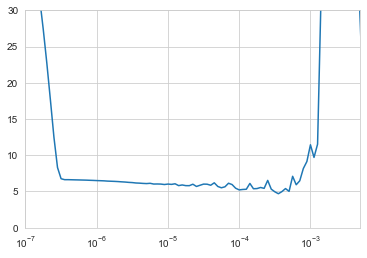

In [39]:
plt.semilogx(history.history['lr'],history.history['loss'])
plt.axis([1e-7,5e-3,0,30])

In [40]:
# tunning

In [41]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 30
train_set = window_dataset(X_train,window_size)

In [42]:
model = keras.models.Sequential([
    keras.layers.Dense(10,activation='relu',input_shape=[window_size]),
    keras.layers.Dense(10,activation='relu'),
    keras.layers.Dense(1)
])

In [43]:
optimizer = keras.optimizers.SGD(learning_rate=1e-5,momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

In [44]:
early_stooping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set,epochs=500,
         validation_data=valid_set,
         callbacks=[early_stooping])

Epoch 1/500
31/31 [==============================] - 2s 31ms/step - loss: 16.2289 - mae: 16.7245 - val_loss: 10.4791 - val_mae: 10.9731
Epoch 2/500
31/31 [==============================] - 1s 21ms/step - loss: 6.6341 - mae: 7.1162 - val_loss: 6.3069 - val_mae: 6.7853
Epoch 3/500
31/31 [==============================] - 1s 20ms/step - loss: 6.7049 - mae: 7.1878 - val_loss: 6.1894 - val_mae: 6.6700
Epoch 4/500
31/31 [==============================] - 1s 21ms/step - loss: 6.3316 - mae: 6.8113 - val_loss: 6.0314 - val_mae: 6.5122
Epoch 5/500
31/31 [==============================] - 1s 21ms/step - loss: 6.1801 - mae: 6.6569 - val_loss: 5.8426 - val_mae: 6.3233
Epoch 6/500
31/31 [==============================] - 1s 21ms/step - loss: 6.2915 - mae: 6.7719 - val_loss: 5.7773 - val_mae: 6.2678
Epoch 7/500
31/31 [==============================] - 1s 21ms/step - loss: 6.1366 - mae: 6.6161 - val_loss: 5.8739 - val_mae: 6.3556
Epoch 8/500
31/31 [==============================] - 1s 20ms/step - loss

31/31 [==============================] - 1s 19ms/step - loss: 5.0879 - mae: 5.5676 - val_loss: 5.0014 - val_mae: 5.4816
Epoch 63/500
31/31 [==============================] - 1s 21ms/step - loss: 5.1172 - mae: 5.5936 - val_loss: 4.9809 - val_mae: 5.4635
Epoch 64/500
31/31 [==============================] - 1s 20ms/step - loss: 5.1324 - mae: 5.6107 - val_loss: 4.9570 - val_mae: 5.4366
Epoch 65/500
31/31 [==============================] - 1s 19ms/step - loss: 5.0875 - mae: 5.5657 - val_loss: 5.0946 - val_mae: 5.5663
Epoch 66/500
31/31 [==============================] - 1s 17ms/step - loss: 5.0798 - mae: 5.5559 - val_loss: 4.9613 - val_mae: 5.4440
Epoch 67/500
31/31 [==============================] - 1s 22ms/step - loss: 5.0573 - mae: 5.5366 - val_loss: 5.0211 - val_mae: 5.4950
Epoch 68/500
31/31 [==============================] - 1s 22ms/step - loss: 5.0487 - mae: 5.5277 - val_loss: 5.1196 - val_mae: 5.5917
Epoch 69/500
31/31 [==============================] - 1s 21ms/step - loss: 5.1585 

31/31 [==============================] - 1s 20ms/step - loss: 4.7441 - mae: 5.2170 - val_loss: 4.7732 - val_mae: 5.2556
Epoch 124/500
31/31 [==============================] - 1s 21ms/step - loss: 4.6940 - mae: 5.1688 - val_loss: 4.8052 - val_mae: 5.2838
Epoch 125/500
31/31 [==============================] - 1s 19ms/step - loss: 4.8425 - mae: 5.3159 - val_loss: 4.9914 - val_mae: 5.4697
Epoch 126/500
31/31 [==============================] - 1s 21ms/step - loss: 4.7709 - mae: 5.2422 - val_loss: 4.7651 - val_mae: 5.2460
Epoch 127/500
31/31 [==============================] - 1s 18ms/step - loss: 4.7003 - mae: 5.1718 - val_loss: 4.7642 - val_mae: 5.2448
Epoch 128/500
31/31 [==============================] - 1s 19ms/step - loss: 4.7610 - mae: 5.2338 - val_loss: 4.7854 - val_mae: 5.2638
Epoch 129/500
31/31 [==============================] - 1s 20ms/step - loss: 4.8247 - mae: 5.2977 - val_loss: 4.7665 - val_mae: 5.2456
Epoch 130/500
31/31 [==============================] - 1s 20ms/step - loss: 

In [45]:
dense_forcast = model_forcast(model,
                             series[split_time-window_size:-1],window_size)[:,0]

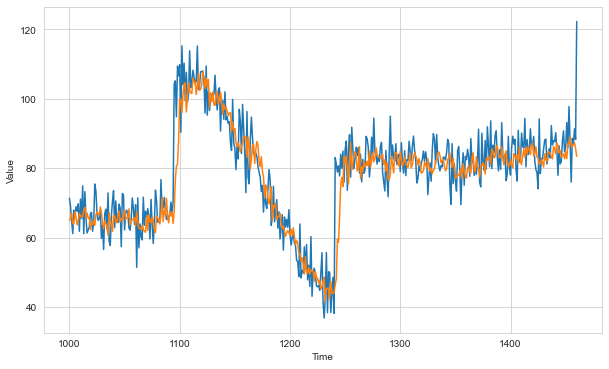

In [47]:
plt.figure(figsize=(10,6))
plot_series(time_valid,X_valid)
plot_series(time_valid,dense_forcast)

In [48]:

keras.metrics.mean_absolute_error(X_valid,dense_forcast).numpy()

5.084706